In [7]:
import torch
if torch.cuda.is_available():
    # May use more memory, but speeds up training
    torch.backends.cudnn.benchmark = True
import sys
sys.path.extend(['../'])
import celldetection as cd
from celldetection import models, toydata
import numpy as np
import os
from collections import OrderedDict
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from matplotlib import pyplot as plt
from torch.cuda.amp import GradScaler, autocast

In [8]:
batch_size = 8
order = 7  # the higher, the more complex shapes can be detected
samples = 128  # number of coordinates per contour

# Change this if your CPU can hangle more/less
num_workers = 8 * int(os.name != 'nt')

# 1. Toy Dataset

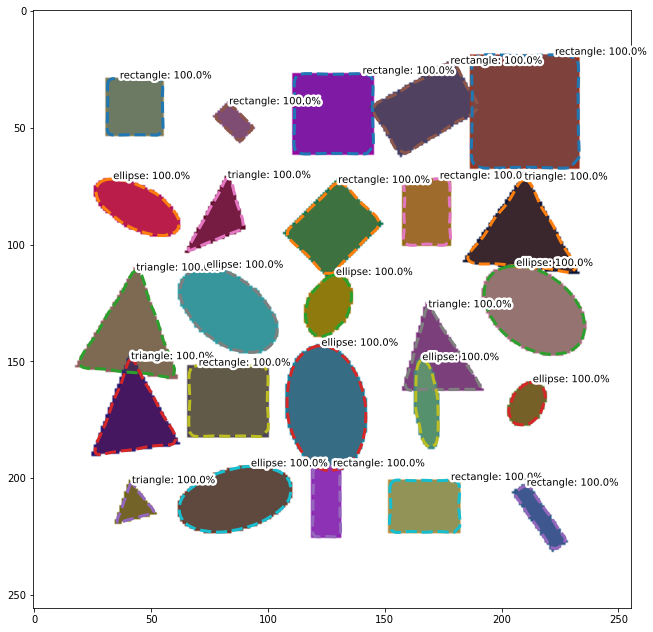

In [9]:
class Dataset:
    def __init__(self, samples, order, items=2**13):
        self.gen = cd.data.CPNTargetGenerator(
            samples=samples,
            order=order,
            min_fg_dist=0.95,
            max_bg_dist=0.90,
        )
        self._items = items
    
    def __len__(self):
        return self._items
    
    @staticmethod
    def map(image):
        image = image / 127.5
        image -= 1
        return image
    
    @staticmethod
    def unmap(image):
        image = (image + 1) * 127.5
        image = np.clip(image, 0, 255).astype('uint8')
        return image
    
    def __getitem__(self, item):
        img, masks, labels, classes = cd.toydata.random_geometric_objects()
        gen = self.gen
        gen.feed(labels=labels)
        
        image = self.map(img)
        return OrderedDict({
            'inputs': image.astype('float32'),
            'labels': gen.reduced_labels,
            'fourier': (gen.fourier.astype('float32'),),
            'locations': (gen.locations.astype('float32'),),
            'sampled_contours': (gen.sampled_contours.astype('float32'),),
            'sampling': (gen.sampling.astype('float32'),),
            'classes': (classes,)  # just comment out this line if you only have two classes
        })
    
train_data = Dataset(samples=samples, order=order)
test_data = Dataset(samples=samples, order=order, items=2)
train_loader = DataLoader(train_data, batch_size=batch_size, num_workers=num_workers, collate_fn=cd.universal_dict_collate_fn)
test_loader = DataLoader(test_data, batch_size=2, num_workers=0, collate_fn=cd.universal_dict_collate_fn)

example = train_data[0]
class_d = cd.toydata.CLASS_NAMES_GEOMETRIC
cd.vis.show_detection(image=Dataset.unmap(example['inputs']), contours=example['sampled_contours'][0],
                      class_name=[class_d[i] for i in example['classes'][0]], scores=np.ones(len(example['classes'][0])),
                      contour_line_width=3, figsize=(11, 11))

# 2. CPN Model
## 2.1 Model

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

encoder = models.UNetEncoder(in_channels=3)
encoder_decoder = models.UNet(encoder, out_channels=1)
model = models.CPN(encoder_decoder, order=order, samples=samples, refinement_iterations=2, nms_thresh=.5,
                   score_thresh=.95, contour_head_stride=4, classes=4)

model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=.0008)
scaler = GradScaler() if torch.cuda.is_available() else None  # set None to disable
print("Device:", device)
print("Optimizer:", optimizer)
print("Use amp:", scaler is not None)

# 3. Training
## 3.1 Training Functions

In [ ]:
OOM = False

def train_epoch(model, train_loder, device, optimizer, epoch, scaler=None):
    model.train()
    for batch_idx, batch in enumerate(tqdm(train_loader, desc="Epoch %d" % epoch)):
        batch = cd.to_device(batch, device)
        optimizer.zero_grad()
        with autocast(scaler is not None):
            outputs = model(batch['inputs'], targets=batch)
        loss = outputs['loss']
        if scaler is None:
            loss.backward()
            optimizer.step()
        else:
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

def show_results(model, test_loader, device):
    global OOM
    d = device
    if OOM:
        d = 'cpu'
        model.cpu()
    model.eval()
    with torch.no_grad():
        batch = next(iter(test_loader))
        batch = cd.to_device(batch, d)
        try:
            outputs = model(batch['inputs'])
        except RuntimeError as e:
            OOM = True
            print(e)
            print("If you do not have enough GPU memory for inference you can:")
            print("\t(a) Do inference on cpu (default, you don't have to do anything)")
            print("\t(b) Set torch.backends.cudnn.benchmark=False (see top of this notebook)")
            show_results(model, test_loader, device)
            return
    o = cd.asnumpy(outputs)
    num = len(o['contours'])
    plt.figure(None, (13 * num, 13))
    for idx in range(num):
        image = cd.asnumpy(batch['inputs'][idx])
        plt.subplot(1, num, idx + 1)
        class_names = [cd.toydata.CLASS_NAMES_GEOMETRIC[j] for j in o['classes'][idx]]
        cd.vis.show_detection(Dataset.unmap(image.transpose(1, 2, 0)), contours=o['contours'][idx],
                              contour_line_width=5, scores=o['scores'][idx], class_name=class_names)
    plt.show()
    if OOM:
        model.to(device)

## 3.2 Training

In [ ]:
for epoch in range(1, 100):
    train_epoch(model, train_loader, device, optimizer, epoch, scaler)
    if epoch % 10 == 0:
        show_results(model, test_loader, device)